<a href="https://colab.research.google.com/github/Fmarcelneves/Twitter_Network_Analytics/blob/main/Twitter_analysis_(exploratory%2C_sentimental_and_networks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading packages 



In [ ]:
%%capture
%matplotlib inline
#data manipulation
import pandas as pd
import numpy as np
import collections
import regex as re 
import random
#data wordcloud
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import visualization
import matplotlib.pyplot as plt
import io
import base64
#networks
import networkx as nx
!pip install python-louvain
from community import community_louvain
#nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
#pickle
import pickle

In [ ]:
%%capture
!pip install plotly --upgrade
from plotly import __version__
print (__version__)
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly as py
#import plotly.figure_factory as ff
from plotly import tools
#import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

In [ ]:
 nltk.download('stopwords')
 nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [ ]:
%%capture
import plotly.io as pio
pio.templates.default = "plotly_white"
#pio.renderers.default = 'colab'

In [ ]:
%%capture
!pip install dash
import dash
!pip install jupyter-dash
from jupyter_dash import JupyterDash
!pip install dash_bootstrap_components
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

## Loading Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/Fmarcelneves/Twitter_Network_Analytics/main/twitter_data_eleicoes-2020.csv'

In [ ]:
twitter_dt = pd.read_csv(url)

In [ ]:
twitter_dt.head(5) 

Id  ...                                           Hashtags
0  1318372291818958849  ...                   [#soumatarazzo55, #eleicoes2020]
1  1318371493361889280  ...  [#melhoragora, #familialgbtq, #bielexpulso, #e...
2  1318371466635747328  ...                                    [#eleicoes2020]
3  1318371443500003329  ...                                    [#eleicoes2020]
4  1318369901417988098  ...  [#juventudeepraviver, #edmarte50024, #eleicoes...

[5 rows x 11 columns]

## Exploratory analysis 

In [ ]:
twitter_dt.shape

(122851, 11)

In [ ]:
twitter_dt.describe()

Id       Retweets       Curtidas    Seguidores
count  1.228510e+05  122851.000000  122851.000000  1.228510e+05
mean   1.323883e+18       2.532727      17.526296  1.221476e+05
std    3.572271e+15      16.214915     144.410152  7.935031e+05
min    1.316913e+18       0.000000       0.000000  2.100000e+01
25%    1.320828e+18       0.000000       0.000000  4.380000e+02
50%    1.323981e+18       0.000000       2.000000  2.702000e+03
75%    1.327317e+18       1.000000       7.000000  2.710300e+04
max    1.329492e+18    2121.000000   11958.000000  1.181385e+07

In [ ]:
twitter_dt_dummy = twitter_dt.copy()
twitter_dt_dummy.loc[twitter_dt_dummy['Retweets'] != 0, 'Retweets'] = "Presente"
twitter_dt_dummy.loc[twitter_dt_dummy['Retweets'] == 0, 'Retweets'] = "Ausente"
twitter_dt_dummy.loc[twitter_dt_dummy['Curtidas'] != 0, 'Curtidas'] = "Presente"
twitter_dt_dummy.loc[twitter_dt_dummy['Curtidas'] == 0, 'Curtidas'] = "Ausente"
twitter_dt_dummy = twitter_dt_dummy[['Retweets', 'Curtidas', 'Usuário_verificado', 'Mídia']]

In [ ]:
pd.options.plotting.backend = "plotly"

In [ ]:
fig1 = twitter_dt_dummy['Retweets'].value_counts().plot.bar(color = ['Ausente', 'Presente'], title = "Retweets", labels={"value": "Frequências", "index": "", 'color': ''})
fig1.show()

In [ ]:
fig2 = twitter_dt_dummy['Curtidas'].value_counts().reindex(["Ausente", "Presente"]).plot.bar(color = ['Ausente', 'Presente'], title = "Curtidas no tweet", 
      labels={"value": "Frequências", "index": "", 'color': ''})
fig2.show()

In [ ]:
fig3 = twitter_dt['Mídia'].value_counts().plot.bar(color = ['Ausente', 'Presente'],  title = "Mídia", 
                                                   labels={"value": "Frequências", "index": "", 'color': ''})
fig3.show()

In [ ]:
index_names= twitter_dt[ (twitter_dt['Retweets'] <= 10)].index
twitter_dt_rt = twitter_dt.drop(index_names) 
fig4 = twitter_dt_rt['Retweets'].plot.hist(title = "Frequência de retweets", bins= 80, 
                                           labels={"count": "Frequências", "value": "Retweets", 'variable': ''})
fig4.show()

In [ ]:
index_names= twitter_dt[(twitter_dt['Curtidas'] <= 10)].index
twitter_dt_ct = twitter_dt.drop(index_names) 
fig5 = twitter_dt_ct['Curtidas'].plot.hist(title = "Frequência de curtidas", bins = 80,
labels={"count": "Frequências", "value": "Curtidas", "variable": ""})
fig5

In [ ]:
index_names= twitter_dt[ (twitter_dt['Seguidores'] <= 30)].index
twitter_dt_sg = twitter_dt.drop(index_names) 
fig6 = twitter_dt_sg['Seguidores'].plot.hist(title = "Frequência de seguidores", bins = 100000, 
labels={"count": "Frequências", "value": "Seguidores", "variable":""})
fig6.show()

In [ ]:
fig7 = px.scatter(twitter_dt, x="Retweets", color="Usuário_verificado", marginal_x ="box", facet_col="Mídia", title = "Número de retweets na presença e ausência de mídia", 
labels={"index": "Frequências", "Usuário_verificado": "Usuário verificado"})
fig7.show()

In [ ]:
twitter_dt_tempo = twitter_dt.groupby([twitter_dt['Tempo'].astype('datetime64[ns]').dt.to_period('1d')]).count()
fig8=px.bar(twitter_dt_tempo, x=twitter_dt_tempo.index.astype(str) , y="Id", labels={"Id": "Frequências", "x": "Tempo"},
       title="Frequências dos tweets ao longo do tempo", color = twitter_dt_tempo['Id'])
fig8.show() 

In [ ]:
correlation = twitter_dt[["Seguidores", "Retweets", "Curtidas"]].corr()
fig9 = px.imshow(correlation, labels=dict(color="Correlação"), title="Correlação entre as variáveis numéricas")
#fig.update_layout(width=800, height=800)
fig9.show()

In [ ]:
net1 = pd.DataFrame(twitter_dt['Nome_do_usuário'])
net2 = pd.DataFrame(twitter_dt['Hashtags'].str.split().values.tolist())
net_rtc = pd.DataFrame(twitter_dt[['Nome_do_usuário', 'Retweets']])    

In [ ]:
net_all = pd.concat([net1, net2.reindex(net1.index)], axis=1)
net_all = net_all.melt(id_vars="Nome_do_usuário")

In [ ]:
net_all['value'] = net_all['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_all['value'].replace('', np.nan, inplace=True)
net_all.dropna(inplace=True)

In [ ]:
net_all.drop(['variable'], axis=1, inplace=True)

In [ ]:
net_all_word = net_all

In [ ]:
net_all["count"] = 1
net_all = net_all.groupby(["Nome_do_usuário", "value"])["count"].count().reset_index()

In [ ]:
pd.options.plotting.backend = "plotly"

In [ ]:
net_all_word

Nome_do_usuário                value  count
0         danialvesceiri      #soumatarazzo55      1
1        eitatiozemorgon         #melhoragora      1
2               Gu_rebel        #eleicoes2020      1
3             nenoticias        #eleicoes2020      1
4               Ed_Marte  #juventudeepraviver      1
...                  ...                  ...    ...
2692232         tauantes        #eleicoes2020      1
2696145         tauantes        #eleicoes2020      1
2770000    porcoespirito                 #boi      1
2815083         tauantes      #jornaldarecord      1
2818996         tauantes      #jornaldarecord      1

[347393 rows x 3 columns]

In [ ]:
fig10 = twitter_dt["Nome_do_usuário"].value_counts().nlargest(10).plot(kind='barh',title="Contas do twitter mais ativas", 
labels={"value": "Número de Tweets", "index": "Contas do Twitter", 'color': 'Frequência'}, color = twitter_dt["Nome_do_usuário"].value_counts().nlargest(10))
fig10.update_layout(showlegend=False)

In [ ]:
followers = twitter_dt.sort_values(by = "Seguidores", ascending = False)
user_most_followers = twitter_dt.groupby("Nome_do_usuário").max().sort_values(by = "Seguidores", ascending = False)
user_most_followers["Nome_do_usuário"] = user_most_followers.index
user_most_followers.reset_index(inplace = True, drop = True)
fig11=px.bar(user_most_followers[:10], x = "Nome_do_usuário", y = "Seguidores", color = "Usuário_verificado", title="Usuários com maior número de seguidores", 
             labels={"Seguidores": "Seguidores", "Nome_do_usuário": "Usuários", 'Usuário_verificado': 'Usuário verificado'})
fig11.show()

In [ ]:
retweeted = twitter_dt.sort_values(by = "Retweets", ascending = False)
user_most_retweeted = twitter_dt.groupby("Nome_do_usuário").max().sort_values(by = "Retweets", ascending = False)
user_most_retweeted['Nome_do_usuário'] = user_most_retweeted.index
user_most_retweeted.reset_index(inplace = True, drop = True)
fig12 = px.bar(user_most_retweeted[:10], x = 'Nome_do_usuário', y = "Retweets", color = "Usuário_verificado", title="Usuários com maior número de retweets", 
               labels={"Nome_do_usuário": "Nome do usuário", 'Usuário_verificado': 'Usuário verificado'})
fig12.update_layout(xaxis_categoryorder = 'total descending')
fig12.show()

## Wordcloud

In [ ]:
url = 'https://raw.githubusercontent.com/Fmarcelneves/Twitter_Network_Analytics/main/stopwords.txt'

In [ ]:
stopwords= set(STOPWORDS)
#Adicionando a lista stopwords em português
new_words = []
with open('stopwords.txt', 'r') as f:
    [new_words.append(word) for line in f for word in line.split()]

new_stopwords = stopwords.union(new_words + ["#eleicoes2020"])


#Adicionando a lista stopwords em português

In [ ]:
import io
import base64

In [ ]:
Hashtag_Combined = " ".join(twitter_dt['Hashtags'].dropna())
text = Hashtag_Combined.replace("eleicoes2020", "").replace("eleicoe", "").replace("election2020", "elections2020").replace("smunicipais", "eleicoesmunicipais").replace("samaericanas2020", "eleicoesamericanas2020").replace("snoseua", "eleicoesnoseua").replace("seua", "eleicoeseua")

In [ ]:
text

'[#soumatarazzo55, #] [#melhoragora, #familialgbtq, #bielexpulso, #, #melhoragora] [#] [#] [#juventudeepraviver, #edmarte50024, #] [#, #blumenau] [#moacir12, #] [#moacir12, #saojosemelhorpratodos, #] [#] [#, #votoutil2020, #votecerto, #votoconsciente] [#moacir12, #saojosemelhorpratodos, #] [#] [#] [#agenda, #candidatos, #] [#, #] [#lutamburinivereadora, #] [] [#] [#, #debate, #pozzobom] [] [#, #portoalegre] [#eleicoeseua, #, #uselections2020] [#] [#, #parahyba, #joaopessoa] [] [#] [#] [#, #eduardopaes, #linhaamarela] [#] [#, #bouloserundina50, #virasp50] [#, #s, #s, #acordapovo] [#gugu17040, #rio, #riodejaneiro, #, #vereadores, #vereadordorio, #carioca, #aeducacaotemopcao, #educacaodebase, #oriotemopcao] [#soumatarazzo55, #saopaulo, #matarazzoprefeito, #, #prefeitosp] [#vcdecide, #] [#, #vereador, #politica, #amoraoproximo, #riodejaneiro, #rj, #errejota, #carioca, #gratidao, #familia, #trabalhandojuntos, #trabalho, #compromiso, #saude, #educacao, #amor, #seguranca] [#, #celsinhocotrim]

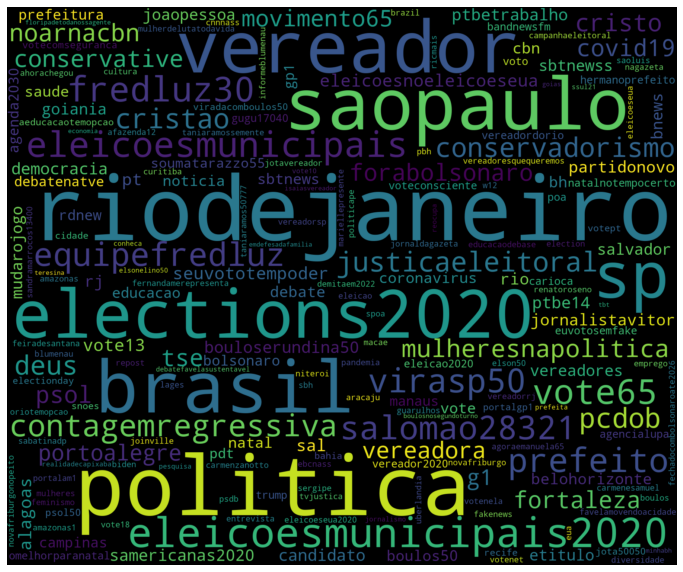

In [ ]:
#Word Cloud
fig14 = WordCloud(background_color="black", stopwords=STOPWORDS, width=1800, height=1500, collocations=False)
text = Hashtag_Combined.replace("eleicoes2020", "").replace("eleicoe", "").replace("election2020", "elections2020").replace("smunicipais", "eleicoesmunicipais").replace("samaericanas2020", "eleicoesamericanas2020").replace("snoseua", "eleicoesnoseua").replace("seua", "eleicoeseua")
fig14.generate(text)
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(fig14, interpolation='bilinear');

In [ ]:
teste = str(list(net_all_word['value']))

In [ ]:
hash_freq = net_all_word[~net_all_word.value.str.contains("#eleicoes2020")]

In [ ]:
wordcloud = pd.DataFrame(hash_freq['value'].value_counts().nlargest(200))

In [ ]:
text = list(wordcloud.index)
frequency = list(wordcloud.value)

In [ ]:
words = text
frequency = frequency

lower, upper = 5, 45
frequency = [((x - min(frequency)) / (max(frequency) - min(frequency))) * (upper - lower) + lower for x in frequency]

lenth = len(words)

colors = [py.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(lenth)]

py.colors

data = go.Scatter(x=random.choices(range(lenth), k=lenth),  
 y=random.choices(range(lenth), k=lenth),
mode='text',
text=words,
hovertext=['{0} {1}'.format(w, f) for w, f in zip(words, frequency)],
hoverinfo='text',
textfont={'size': frequency, 'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}}, 
                   margin=dict(l=25, r=25, t=25, b=25), title="Wordcloud das Hashtags presentes nos tweets")

fig13 = go.Figure(data=[data], layout=layout)
fig13.show()

In [ ]:
hash_freq = net_all_word[~net_all_word.value.str.contains("#eleicoes2020")]
fig14=hash_freq['value'].value_counts().nlargest(15).plot(kind='bar', title="Frequência das Hashtags presentes nos tweets", labels={"_value": "Frequências", "index": "Hashtags", 'color': 'Frequência'}, color = hash_freq['value'].value_counts().nlargest(15))
fig14.update_layout(showlegend=False)

## Noise Removal Remove urls from text (http(s), www)


In [ ]:
def _remove_url(data):
    ls = []
    words = ''
    regexp1 = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regexp2 = re.compile('www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    for line in data:
        urls = regexp1.findall(line)

        for u in urls:
            line = line.replace(u, ' ')

        urls = regexp2.findall(line)

        for u in urls:
            line = line.replace(u, ' ')
            
        ls.append(line)
    return ls

In [ ]:
sa_twitter_dt = _remove_url(twitter_dt['Tweet'])

In [ ]:
def _remove_regex(data, regex_pattern):
    ls = []
    words = ''
    
    for line in data:
        matches = re.finditer(regex_pattern, line)
        
        for m in matches: 
            line = re.sub(m.group().strip(), '', line)

        ls.append(line)

    return ls

In [ ]:
# notations
regex_pattern = '@[\w]*'
sa_twitter_dt = _remove_regex(sa_twitter_dt, regex_pattern)

# check data
for i in range(0, 5):
    print(sa_twitter_dt[i])

Boa noite à todos vocês que desejam uma cidade melhor! #soumatarazzo55 #eleições2020
Que programa incrível #melhoragora #FamiliaLGBTQ #BielExpulso #Eleicoes2020 #MelhorAgora
#Eleições2020 Comissão de debate anuncia nova regra de desligar o microfone de quem desrespeitar a vez do coleguinha de falar.
Confira a Tabela dos locais de votação em Sergipe. #Eleicoes2020
Recebi com muita emoção e alegria esse vídeo do jovem William, o DJ Wn, um querido que conheci no sistema socioeducativo numa das oficinas com as juventudes. #juventudeépraviver #edmarte50024 #Eleicoes2020


In [ ]:
# rt
regex_pattern = 'RT[\w]*'
sa_twitter_dt = _remove_regex(sa_twitter_dt, regex_pattern)

In [ ]:
# hashtags
regex_pattern = '#[\w]*'
sa_twitter_dt = _remove_regex(sa_twitter_dt, regex_pattern)

In [ ]:
# notations
regex_pattern = '@[\w]*'
sa_twitter_dt = _remove_regex(sa_twitter_dt, regex_pattern)

In [ ]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

In [ ]:
# emoji pattern 
regex_pattern = emoji_pattern 
sa_twitter_dt = _remove_regex(sa_twitter_dt, regex_pattern)

In [ ]:
# check data
for i in range(0, 5):
    print(sa_twitter_dt[i])

Boa noite à todos vocês que desejam uma cidade melhor!  
Que programa incrível     
 Comissão de debate anuncia nova regra de desligar o microfone de quem desrespeitar a vez do coleguinha de falar.
Confira a Tabela dos locais de votação em Sergipe. 
Recebi com muita emoção e alegria esse vídeo do jovem William, o DJ Wn, um querido que conheci no sistema socioeducativo numa das oficinas com as juventudes.   


In [ ]:
def _replace_emoticons(data, emoticon_list):
    ls = []

    for line in data:
        for exp in emoticon_list:
            line = line.replace(exp, emoticon_list[exp])

        ls.append(line)

    return ls

In [ ]:
emoticon_list = {':))': 'emoticon_positivo', ':)': 'emoticon_positivo', ':D': 'emoticon_positivo', ':(': 'emoticon_negativo', ':((': 'emoticon_negativo', '8)': 'emoticon_neutro'}

In [ ]:
sa_twitter_dt = _replace_emoticons(sa_twitter_dt, emoticon_list)

In [ ]:
# check data
for i in range(0, 5):
    print(sa_twitter_dt[i])

Boa noite à todos vocês que desejam uma cidade melhor!  
Que programa incrível     
 Comissão de debate anuncia nova regra de desligar o microfone de quem desrespeitar a vez do coleguinha de falar.
Confira a Tabela dos locais de votação em Sergipe. 
Recebi com muita emoção e alegria esse vídeo do jovem William, o DJ Wn, um querido que conheci no sistema socioeducativo numa das oficinas com as juventudes.   


In [ ]:
def _tokenize_text(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [ ]:
 sa_twitter_dt_tokens = _tokenize_text(sa_twitter_dt)

In [ ]:
# check data
for i in range(0, 5):
    print(sa_twitter_dt_tokens [i])

['Boa', 'noite', 'à', 'todos', 'vocês', 'que', 'desejam', 'uma', 'cidade', 'melhor', '!']
['Que', 'programa', 'incrível']
['Comissão', 'de', 'debate', 'anuncia', 'nova', 'regra', 'de', 'desligar', 'o', 'microfone', 'de', 'quem', 'desrespeitar', 'a', 'vez', 'do', 'coleguinha', 'de', 'falar', '.']
['Confira', 'a', 'Tabela', 'dos', 'locais', 'de', 'votação', 'em', 'Sergipe', '.']
['Recebi', 'com', 'muita', 'emoção', 'e', 'alegria', 'esse', 'vídeo', 'do', 'jovem', 'William', ',', 'o', 'DJ', 'Wn', ',', 'um', 'querido', 'que', 'conheci', 'no', 'sistema', 'socioeducativo', 'numa', 'das', 'oficinas', 'com', 'as', 'juventudes', '.']


### Object Standardization

In [ ]:
def _apply_standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [ ]:
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também', 'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo', 'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [ ]:
sa_twitter_dt_tokens = _apply_standardization(sa_twitter_dt_tokens, std_list)

In [ ]:
sa_twitter_dt_tokens[0]

['Boa',
 'noite',
 'à',
 'todos',
 'vocês',
 'que',
 'desejam',
 'uma',
 'cidade',
 'melhor',
 '!']

In [ ]:
def _remove_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [ ]:
stopword_list = []

In [ ]:
# get nltk portuguese stopwords
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')

In [ ]:
# You can also add stopwords manually instead of loading from the database. Generally, we add stopwords that belong to this context.
stopword_list.append('é')
stopword_list.append('vou')
stopword_list.append('que')
stopword_list.append('tão')
stopword_list.append('...')
stopword_list.append('«')
stopword_list.append('➔')
stopword_list.append('|')
stopword_list.append('//')
stopword_list.append('/')
stopword_list.append(':')
stopword_list.append('-')
stopword_list.append(';')
stopword_list.append('»')
stopword_list.append('…')
stopword_list.append(')')
stopword_list.append('(')
stopword_list.append(']')
stopword_list.append('[')
stopword_list.append('((')
stopword_list.append('))')
stopword_list.append('emoticon_positivo') 
stopword_list.append('emoticon_negativo')
stopword_list.append('emoticon_neutro')
stopword_list.append('uai') # 'expression from the mineiros (MG/Brazil)'

In [ ]:
stopword_list.extend(nltk_stopwords)

In [ ]:
stopword_list = list(set(stopword_list))

In [ ]:
sa_twitter_dt_tokens = _remove_stopwords(sa_twitter_dt_tokens, stopword_list)

In [ ]:
# check data
for i in range(0, 5):
    print(sa_twitter_dt_tokens[i])

['Boa', 'noite', 'todos', 'desejam', 'cidade', 'melhor', '!']
['programa', 'incrível']
['Comissão', 'debate', 'anuncia', 'nova', 'regra', 'desligar', 'microfone', 'desrespeitar', 'vez', 'coleguinha', 'falar', '.']
['Confira', 'Tabela', 'locais', 'votação', 'Sergipe', '.']
['Recebi', 'muita', 'emoção', 'alegria', 'vídeo', 'jovem', 'William', ',', 'DJ', 'Wn', ',', 'querido', 'conheci', 'sistema', 'socioeducativo', 'oficinas', 'juventudes', '.']


### Stemming (dimensionality reduction)

In [ ]:
def _apply_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [ ]:
sa_twitter_dt_tokens = _apply_stemmer(sa_twitter_dt_tokens)

In [ ]:
# check data
for i in range(0, 5):
    print(sa_twitter_dt_tokens[i])

['boa', 'noit', 'tod', 'desej', 'cidad', 'melhor', '!']
['program', 'incr']
['comiss', 'debat', 'anunc', 'nov', 'regr', 'deslig', 'microfon', 'desrespe', 'vez', 'coleg', 'fal', '.']
['conf', 'tabel', 'local', 'vot', 'sergip', '.']
['receb', 'muit', 'emoç', 'alegr', 'víde', 'jov', 'will', ',', 'dj', 'wn', ',', 'quer', 'conhec', 'sistem', 'socioeduc', 'oficin', 'juventud', '.']


### Untokenize text (transform tokenized text into string list)

In [ ]:
def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [ ]:
sa_twitter_dt = _untokenize_text(sa_twitter_dt_tokens)

In [ ]:
# check data
for i in range(0, 5):
    print(sa_twitter_dt[i])

boa noit tod desej cidad melhor ! 
program incr 
comiss debat anunc nov regr deslig microfon desrespe vez coleg fal . 
conf tabel local vot sergip . 
receb muit emoç alegr víde jov will , dj wn , quer conhec sistem socioeduc oficin juventud . 


### Incorporar o modelo de análise de sentimentos 

In [ ]:
model = "https://github.com/Fmarcelneves/Twitter_Network_Analytics/blob/main/LR_model_we"

In [ ]:
loaded_model = pickle.load(open('LR_model_we', 'rb'))

In [ ]:
labels_sentiments= loaded_model.predict(sa_twitter_dt)

In [ ]:
 Sentimento_tweet = pd.DataFrame(labels_sentiments, columns = ['Sentimento'])

In [ ]:
twitter_dt['Sentimento_tweet'] = Sentimento_tweet

In [ ]:
twitter_dt.head()

Id  ... Sentimento_tweet
0  1318372291818958849  ...         Positivo
1  1318371493361889280  ...         Positivo
2  1318371466635747328  ...           Neutro
3  1318371443500003329  ...           Neutro
4  1318369901417988098  ...           Neutro

[5 rows x 12 columns]

### Análise de sentimentos 

In [ ]:
twitter_dt['Sentimento_tweet'].describe()

count     122851
unique         3
top       Neutro
freq       65412
Name: Sentimento_tweet, dtype: object

In [ ]:
twitter_dt['Sentimento_tweet'].value_counts()

Neutro      65412
Positivo    42936
Negativo    14503
Name: Sentimento_tweet, dtype: int64

In [ ]:
pd.options.plotting.backend = "plotly"

In [ ]:
fig15 = twitter_dt['Sentimento_tweet'].value_counts().plot.bar(color = ['Neutro', 'Positivo', 'Negativo'], title = "Sentimentos presentes nos tweets", 
                                                               labels={"value": "Frequências", "index": "", 'color': ''}, color_discrete_sequence =['#00CC96', '#636EFA', '#EF553B'])
fig15.show()

In [ ]:
Positivo = twitter_dt[(twitter_dt['Sentimento_tweet'] == "Positivo")]
Negativo= twitter_dt[(twitter_dt['Sentimento_tweet'] == "Negativo")]
Neutro= twitter_dt[(twitter_dt['Sentimento_tweet'] == "Neutro")]

In [ ]:
print(Positivo['Tweet'].sample(5).values)

['Hoje tem happy hour com @juliovellozo, pensador, professor e historiador, amigo de grandes conversas e parceiro de Inimigos do Batente. Estamos juntos com @orlandosilva e o @pcdob_saopaulo Às 17h, apareçam! #railidia65670 #agoraRai #Eleicoes2020'
 'Quis saber do @capitao_wagner, candidato do presidente @jairbolsonaro, qual é o posicionamento dele sobre a destruição da democracia e a retirada de direitos, coisa que Bolsonaro tem feito. Wagner fugiu da pergunta. #renatoroseno #debatetvotimista #eleicoes2020'
 'Noite de animação e alegria em #Coaraci com a grande carreata do candidato a prefeito Nino Torquato e vice Rosival Carneiro. Muita gente unida na certeza de fazer uma Coaraci cada vez melhor! Vamos nessa! #Bahia #Eleições2020'
 'Tawane Theodoro descomplica as funções de prefeitos e vereadores no vídeo de hoje, além de explicar como eleições municipais podem afetar no Congresso. ✨As infos são do @congemfoco. #DáUmReload e vamos de likes e RTs! #Eleições2020 #EleiçõesMunicipais #Pr

In [ ]:
print(Neutro['Tweet'].sample(5).values)

['Benedita da Silva vota na Zona Sul do Rio. A candidata vai acompanhar a apuração em casa com a família. #Eleições2020 #BandNewsFM'
 'SBT Eleições 2020, Rio: Crivella promete fim de pedágio na Transolímpica. O atual prefeito do Rio participou da sabatina do SBT News. Leia e assista a íntegra da entrevista #sbtnewseleicoes #Eleicoes2020'
 'Outras cinco legendas tiveram mais de 100 candidatos barrados para as #Eleições2020 de 15 de novembro: DEM, com 113 candidaturas; PP com 108; PL com 106 baixas, PSB com 102 e Republicanos, com 100 candidaturas indeferidas.'
 'No Dia do Funcionário Público, candidato a prefeito de Manaus lavrou documento se comprometendo a cumprir as ações para revisão do Plano de Cargos, Carreiras e Remunerações e melhorias na ManausMed, Manausprev, habitação e trabalho.'
 'Que a cada pleito tenhamos mais representantes. #Eleicoes2020 🌈 ✌️']


In [ ]:
print(Negativo['Tweet'].sample(5).values)

['Por favor, não votem no Crivella!! #Eleicoes2020 #EleicoesRJ #ForaCrivella'
 'Eu fico chocado que a minha cidade que não tem nem 70.000 pessoas, tem mais de 170 candidatos pra 16 VAGAS de vereadores #Eleicoes2020'
 '"E teve boatos que eu estava na pior...se isso é estar na pior, porran..." #Eleicoes2020 #EleicoesMunicipais2020 #BoulosNoSegundoTurno #BoulosErundina50 #ManuelaDavila #Manu65'
 'Candidato a vereador faz campanha com o número errado e só descobre no dia da eleição #alagoas #eleicoesal #eleicoes2020'
 'Alô Goiânia, votei nesse camarada e não voto mais! #vanderlan55 #eleicoes2020 #Goiânia']


In [ ]:
Positivo.head()

Id  ... Sentimento_tweet
0  1318372291818958849  ...         Positivo
1  1318371493361889280  ...         Positivo
5  1318367458626076677  ...         Positivo
6  1318367258247352320  ...         Positivo
7  1318367086641631234  ...         Positivo

[5 rows x 12 columns]

In [ ]:
net1_pos = pd.DataFrame(Positivo['Nome_do_usuário'])
net2_pos = pd.DataFrame(Positivo['Menções_de_usuários'].str.split().values.tolist())   

In [ ]:
net_all_pos = pd.concat([net1_pos, net2_pos.reindex(net1.index)], axis=1)
net_all_pos = net_all_pos.melt(id_vars='Nome_do_usuário')

In [ ]:
net_all_pos['value'] = net_all_pos['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_all_pos['value'].replace('', np.nan, inplace=True)
net_all_pos.dropna(inplace=True)

In [ ]:
net_all_pos.drop(['variable'], axis=1, inplace=True)

In [ ]:
net_all_word_pos = net_all_pos

In [ ]:
teste_pos = str(list(net_all_word_pos['value']))

In [ ]:
hash_freq_pos = net_all_word_pos[~net_all_word_pos.value.str.contains("#eleicoes2020")]

In [ ]:
wordcloud_pos = pd.DataFrame(hash_freq_pos['value'].value_counts().nlargest(200))

In [ ]:
text_pos = list(wordcloud_pos.index)
frequency_pos = list(wordcloud_pos.value)

In [ ]:
words = text_pos
frequency = frequency_pos

lower, upper = 5, 45
frequency = [((x - min(frequency)) / (max(frequency) - min(frequency))) * (upper - lower) + lower for x in frequency]

lenth = len(words)

colors = '#1f77b4'

data = go.Scatter(x=random.choices(range(lenth), k=lenth),  
 y=random.choices(range(lenth), k=lenth),
mode='text',
text=words,
hovertext=['{0} {1}'.format(w, f) for w, f in zip(words, frequency)],
hoverinfo='text',
textfont={'size': frequency, 'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}}, 
                   margin=dict(l=25, r=25, t=25, b=25), title="Wordcloud das Menções em tweets positivos")

fig16 = go.Figure(data=[data], layout=layout)
fig16.show()

In [ ]:
net1_neg = pd.DataFrame(Negativo['Nome_do_usuário'])
net2_neg = pd.DataFrame(Negativo['Menções_de_usuários'].str.split().values.tolist())   

In [ ]:
net_all_neg = pd.concat([net1_neg, net2_neg.reindex(net1.index)], axis=1)
net_all_neg = net_all_neg.melt(id_vars='Nome_do_usuário')

In [ ]:
net_all_neg['value'] = net_all_neg['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_all_neg['value'].replace('', np.nan, inplace=True)
net_all_neg.dropna(inplace=True)

In [ ]:
net_all_neg.drop(['variable'], axis=1, inplace=True)

In [ ]:
net_all_word_neg = net_all_neg

In [ ]:
hash_freq_neg = net_all_word_neg[~net_all_word_neg.value.str.contains("#eleicoes2020")]

In [ ]:
wordcloud_neg = pd.DataFrame(hash_freq_neg['value'].value_counts().nlargest(200))

In [ ]:
text_neg = list(wordcloud_neg.index)
frequency_neg = list(wordcloud_neg.value)

In [ ]:
words = text_neg
frequency = frequency_neg

lower, upper = 5, 45
frequency = [((x - min(frequency)) / (max(frequency) - min(frequency))) * (upper - lower) + lower for x in frequency]

lenth = len(words)

colors = '#d62728'

data = go.Scatter(x=random.choices(range(lenth), k=lenth),  
 y=random.choices(range(lenth), k=lenth),
mode='text',
text=words,
hovertext=['{0} {1}'.format(w, f) for w, f in zip(words, frequency)],
hoverinfo='text',
textfont={'size': frequency, 'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}}, 
                   margin=dict(l=25, r=25, t=25, b=25), title="Wordcloud das Menções em tweets negativos")

fig17 = go.Figure(data=[data], layout=layout)
fig17.show()

In [ ]:
Positivo_count= pd.DataFrame(Positivo['Tempo'].groupby([Positivo['Tempo'].astype('datetime64[ns]').dt.to_period('1d')]).count())
Negativo_count= pd.DataFrame(Negativo['Tempo'].groupby([Negativo['Tempo'].astype('datetime64[ns]').dt.to_period('1d')]).count())
Positivo_count['perc']= Positivo_count['Tempo']/Positivo_count['Tempo'].sum()*100
Negativo_count['perc']= Negativo_count['Tempo']/Negativo_count['Tempo'].sum()*100

In [ ]:
data = [go.Scatter(x=Positivo_count.index.astype(str) , y=Positivo_count['perc'], name='Positivo', yaxis='y2'), 
go.Scatter(x=Negativo_count.index.astype(str) , y=Negativo_count['perc'], name='Negativo')]
# settings for the new y axis
y2 = go.layout.YAxis(overlaying='y', side='right')
# adding the second y axis
layout = go.Layout(yaxis2=y2)
fig18 = go.Figure(data=data, layout=go.Layout(yaxis2=y2))
fig18.update_layout(title="Frequências dos tweets positivos e negativos ao longo do tempo", xaxis_title="Tempo", yaxis_title="Frequências(%)")
iplot(fig18)

## Redes

In [ ]:
net_rt = pd.concat([net_rtc, net2.reindex(net_rtc.index)], axis=1)
net_rt = net_rt.melt(id_vars=['Nome_do_usuário', 'Retweets'])

In [ ]:
net_rt['value'] = net_rt['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_rt['value'].replace('', np.nan, inplace=True)
net_rt.dropna(inplace=True)

In [ ]:
net_rt.drop(['variable'], axis=1, inplace=True)

In [ ]:
net_rt=net_rt[net_rt!=0].dropna()
net_rt = net_rt.groupby(["Nome_do_usuário", "value"])["Retweets"].count().reset_index()

In [ ]:
df = net_rt
df.columns = ['source', 'target', 'weight']

In [ ]:
df_all = net_rt
df_all.columns = ['source', 'target', 'weight']

In [ ]:
df_all_2 = net_rt[~net_rt.target.str.contains("#eleicoes2020")]

In [ ]:
df_all_2

source            target  weight
0       0luangoulart         #campinas       2
1       0luangoulart         #eleicoes       6
3       0luangoulart       #eleicoessp       2
4       0luangoulart  #soutamires13011       6
5       0luangoulart     #tamires13011       6
...              ...               ...     ...
13695  yoshio_carlos    #bolsonaro2022       1
13697  yoshio_carlos      #foraborroso       2
13698  yoshio_carlos              #tse       2
13700    zanelarturo         #boulos50       1
13703  zanonfilho_49        #forakalil       3

[10345 rows x 3 columns]

In [ ]:
df_all_2 = df_all_2.reset_index(drop=True)

In [ ]:
R = nx.from_pandas_edgelist(df_all_2, 'source', 'target', ['weight'])

In [ ]:
for component in list(nx.connected_components(R)):
    if len(component)<10:
        for node in component:
            R.remove_node(node)

In [ ]:
d = dict(R.degree(weight='weight'))

In [ ]:
pos = nx.spring_layout(R)
edges = R.edges()

In [ ]:
for node in R.nodes:
    R.nodes[node]['pos'] = list(pos[node])

In [ ]:
edge_x = []
edge_y = []
for edge in R.edges():
    x0, y0 = R.nodes[edge[0]] ['pos']
    x1, y1 = R.nodes[edge[1]] ['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='text+x+y',
    mode='lines')

node_x = []
node_y = []
for node in R.nodes():
    x, y = R.nodes[node] ['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Viridis',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Centralidade de grau (ponderada)',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
node_adjacencies = []
node_text = [f'<br>label: {sl}' for n, sl in zip(R.nodes, R)]
for node, adjacencies in enumerate(R.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color =  [v/200 for v in d.values()]
node_trace.text = node_text
#node_trace.marker.size = node_adjacencies [i * 5 for i in node_adjacencies]
node_trace.marker.size = [v/200 for v in d.values()] #[i * 5 for i in node_adjacencies]

In [ ]:
fig19 = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Rede de Retweets' 
                '<br>(6605 nós e 9842 arestas)',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=8,r=8,t=40),
                width=750, height=600,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig19.show()

In [ ]:
print(nx.info(R))

Name: 
Type: Graph
Number of nodes: 6605
Number of edges: 9842
Average degree:   2.9802


In [ ]:
groups_fig20 =  collections.Counter(d).most_common(25)
groups_fig20 = pd.DataFrame.from_dict(groups_fig20,  orient='columns')
groups_fig20.columns = ['hashtag ou indivíduo', 'centralidade']

In [ ]:
table_groups_fig20 = go.Figure(data=[go.Table(
    header=dict(values=list(groups_fig20.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=groups_fig20.transpose().values.tolist(),
               fill_color='lavender',
               align='left'))
])
table_groups_fig20.update_layout(margin=dict(l=10, r=10, t=10, b=10),  paper_bgcolor="LightSteelBlue")
table_groups_fig20.show()

In [ ]:
#degree_hist_R = nx.degree_histogram(R)  
#fig = px.histogram(degree_hist_R)
#fig.update_layout(showlegend=False)

In [ ]:
net_all = pd.concat([net1, net2.reindex(net1.index)], axis=1)
net_all = net_all.melt(id_vars="Nome_do_usuário")
net_all['value'] = net_all['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_all['value'].replace('', np.nan, inplace=True)
net_all.dropna(inplace=True)
net_all.drop(['variable'], axis=1, inplace=True)
net_all["count"] = 1
net_all = net_all.groupby(["Nome_do_usuário", "value"])["count"].count().reset_index()

In [ ]:
flattened_hashtags_df = pd.DataFrame(net_all['value'])

In [ ]:
popular_hashtags = flattened_hashtags_df.groupby('value').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [ ]:
# take hashtags which appear at least this amount of times
min_appearance = 5
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['value'])

In [ ]:
# make a new column with only the popular hashtags
popular_hashtags = pd.DataFrame(popular_hashtags_set, columns=['popular_hashtags'])

In [ ]:
popular_hashtags = popular_hashtags.replace('onaro','#bolsonaro')

In [ ]:
popular_hashtags 

popular_hashtags
0           #barroso
1          #pandemia
2    #bidenharis2020
3          #pantanal
4              #arte
..               ...
989       #cobertura
990          #cidade
991        #euvoto35
992          #corona
993             #mpf

[994 rows x 1 columns]

In [ ]:
# make new dataframe
hashtag_vector_df = popular_hashtags.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [ ]:
hashtag_matrix = hashtag_vector_df.set_index('popular_hashtags')

In [ ]:
hashtag_matrix

#barroso  #pandemia  ...  #corona  #mpf
popular_hashtags                       ...               
#barroso                 1          0  ...        0     0
#pandemia                0          1  ...        0     0
#bidenharis2020          0          0  ...        0     0
#pantanal                0          0  ...        0     0
#arte                    0          0  ...        0     0
...                    ...        ...  ...      ...   ...
#cobertura               0          0  ...        0     0
#cidade                  0          0  ...        0     0
#euvoto35                0          0  ...        0     0
#corona                  0          0  ...        1     0
#mpf                     0          0  ...        0     1

[994 rows x 994 columns]

In [ ]:
hash = nx.from_pandas_adjacency(hashtag_matrix)
hash.remove_edges_from(nx.selfloop_edges(hash))

In [ ]:
for component in list(nx.connected_components(hash)):
    if len(component)<5:
        for node in component:
            hash.remove_node(node)

In [ ]:
d = dict(hash.degree(weight='weight'))

In [ ]:
pos = nx.fruchterman_reingold_layout(hash)
edges = hash.edges()

In [ ]:
partition = community_louvain.best_partition(hash, weight='weight')

In [ ]:
colors = [partition[n] for n in hash.nodes()]

In [ ]:
for node in hash.nodes:
    hash.nodes[node]['pos'] = list(pos[node])

In [ ]:
edge_x = []
edge_y = []
for edge in hash.edges():
    x0, y0 = hash.nodes[edge[0]] ['pos']
    x1, y1 = hash.nodes[edge[1]] ['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='text+x+y',
    mode='lines')

node_x = []
node_y = []
for node in hash.nodes():
    x, y = hash.nodes[node] ['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale= 'Rainbow',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Comunidades',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
node_adjacencies = []
node_text = [f'<br>label: {sl}' for n, sl in zip(hash.nodes, hash)]
for node, adjacencies in enumerate(hash.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = colors #[v for v in d.values()] # node_adjacencies
node_trace.text = node_text
#node_trace.marker.size = node_adjacencies [i * 5 for i in node_adjacencies]
node_trace.marker.size = [v*4 for v in d.values()] #[i * 5 for i in node_adjacencies]

In [ ]:
fig21 = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Rede de Hashtags'
                '<br>(227 nós e 247 arestas)',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                width=750, height=600,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig21.show()

In [ ]:
groups_fig22 =  collections.Counter(d).most_common(25)
groups_fig22 = pd.DataFrame.from_dict(groups_fig22,  orient='columns')
groups_fig22.columns = ['hashtags', 'centralidade']

In [ ]:
table_groups_fig22 = go.Figure(data=[go.Table(
    header=dict(values=list(groups_fig22.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=groups_fig22.transpose().values.tolist(),
               fill_color='lavender',
               align='left'))
])
table_groups_fig22.update_layout(margin=dict(l=10, r=10, t=10, b=10),  paper_bgcolor="LightSteelBlue")
table_groups_fig22.show()

In [ ]:
print(nx.info(hash))

Name: 
Type: Graph
Number of nodes: 227
Number of edges: 247
Average degree:   2.1762


In [ ]:
degree_hist_hash = nx.degree_histogram(hash)  
fig = px.histogram(degree_hist_hash)
fig.update_layout(showlegend=False)

In [ ]:
df_all = net_all
df_all.columns = ['source', 'target', 'weight']
#df_all = df_all[df['weight'] != 0]  # remove non-connected nodes

In [ ]:
df_all_2 = net_all[~df_all.target.str.contains("#eleicoes2020")]

In [ ]:
df_all_2 = df_all_2.reset_index(drop=True)

In [ ]:
df_all_2 = df_all_2[df_all_2['weight'] >2]

In [ ]:
net1 = pd.DataFrame(twitter_dt['Nome_do_usuário'])

In [ ]:
net3 = pd.DataFrame(twitter_dt['Menções_de_usuários'].str.split().values.tolist())

In [ ]:
net_mention = pd.concat([net1, net3.reindex(net1.index)], axis=1)
net_mention = net_mention.melt(id_vars="Nome_do_usuário")

In [ ]:
net_mention['value'] = net_mention['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_mention['value'].replace('', np.nan, inplace=True)
net_mention.dropna(inplace=True)

In [ ]:
net_mention.drop(['variable'], axis=1, inplace=True)

In [ ]:
net_mention["count"] = 1
net_mention = net_mention.groupby(["Nome_do_usuário", "value"])["count"].count().reset_index()

In [ ]:
df_mention_all = net_mention
df_mention_all.columns = ['source', 'target', 'weight']
#df_all = df_all[df['weight'] != 0]  # remove non-connected nodes

In [ ]:
df_mention_all.shape

(8354, 3)

In [ ]:
M = nx.from_pandas_edgelist(df_mention_all, 'source', 'target', ['weight'])
M.remove_edges_from(nx.selfloop_edges(M))

In [ ]:
for component in list(nx.connected_components(M)):
    if len(component)<30:
        for node in component:
            M.remove_node(node)

In [ ]:
#fig = figure(figsize=(10, 10))
pos = nx.spring_layout(M)
edges = M.edges()
#weights = [G[u][v]['weight'] for u,v in edges]
#nx.draw(G, pos, linewidths = 0.2, width = [i for i in weights if i<5], node_size = 85, alpha=0.5, node_color="indigo", with_labels=False, font_size=10)

In [ ]:
d = dict(M.degree(weight='weight'))

In [ ]:
for node in M.nodes:
    M.nodes[node]['pos'] = list(pos[node])

In [ ]:
edge_x = []
edge_y = []
for edge in M.edges():
    x0, y0 = M.nodes[edge[0]] ['pos']
    x1, y1 = M.nodes[edge[1]] ['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')

node_x = []
node_y = []
for node in M.nodes():
    x, y = M.nodes[node] ['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        colorbar=dict(
            thickness=10,
            title='Centralidade de grau (ponderada)',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
node_adjacencies = []
node_text = [f'<br>label: {sl}' for n, sl in zip(M.nodes, M)]
for node, adjacencies in enumerate(M.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = [v/50 for v in d.values()] #node_adjacencies
node_trace.text = node_text
node_trace.marker.size = [v/50 for v in d.values()]  #[element * 1.5 for element in node_adjacencies]

In [ ]:
fig23 = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Rede de menções de indivíduos versus indivíduos'
                '<br>(4880 nós e 7144 arestas)',
                titlefont_size=14,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                width=750, height=600,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig23.show()

In [ ]:
groups_fig24 =  collections.Counter(d).most_common(25)
groups_fig24 = pd.DataFrame.from_dict(groups_fig24,  orient='columns')
groups_fig24.columns = ['Menções ou indivíduos', 'centralidade']

In [ ]:
table_groups_fig24 = go.Figure(data=[go.Table(
    header=dict(values=list(groups_fig24.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=groups_fig24.transpose().values.tolist(),
               fill_color='lavender',
               align='left'))
])
table_groups_fig24.update_layout(margin=dict(l=10, r=10, t=10, b=10),  paper_bgcolor="LightSteelBlue")
table_groups_fig24.show()

In [ ]:
print(nx.info(M))

Name: 
Type: Graph
Number of nodes: 4880
Number of edges: 7144
Average degree:   2.9279


In [ ]:
go.table

<module 'plotly.graph_objs.table' from '/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/table/__init__.py'>

In [ ]:
%%capture
!pip install teneto 
from teneto import TemporalNetwork

In [ ]:
net_temp  = pd.concat([twitter_dt['Nome_do_usuário'], twitter_dt['Tempo']], axis = 1)

In [ ]:
net_temp

Nome_do_usuário                Tempo
0        danialvesceiri  2020-10-20 02:03:43
1       eitatiozemorgon  2020-10-20 02:00:32
2              Gu_rebel  2020-10-20 02:00:26
3            nenoticias  2020-10-20 02:00:20
4              Ed_Marte  2020-10-20 01:54:13
...                 ...                  ...
122846    hugobotelho67  2020-11-17 02:13:22
122847          fe___fe  2020-11-17 02:11:39
122848         geladog_  2020-11-17 02:10:52
122849     portal_scc10  2020-11-17 02:07:46
122850         Piaget30  2020-11-17 02:07:09

[122851 rows x 2 columns]

In [ ]:
net_temp = pd.concat([net_temp, net2.reindex(net1.index)], axis=1)

In [ ]:
net_temp

Nome_do_usuário                Tempo  ...    21    22
0        danialvesceiri  2020-10-20 02:03:43  ...  None  None
1       eitatiozemorgon  2020-10-20 02:00:32  ...  None  None
2              Gu_rebel  2020-10-20 02:00:26  ...  None  None
3            nenoticias  2020-10-20 02:00:20  ...  None  None
4              Ed_Marte  2020-10-20 01:54:13  ...  None  None
...                 ...                  ...  ...   ...   ...
122846    hugobotelho67  2020-11-17 02:13:22  ...  None  None
122847          fe___fe  2020-11-17 02:11:39  ...  None  None
122848         geladog_  2020-11-17 02:10:52  ...  None  None
122849     portal_scc10  2020-11-17 02:07:46  ...  None  None
122850         Piaget30  2020-11-17 02:07:09  ...  None  None

[122851 rows x 25 columns]

In [ ]:
net_temp = net_temp.melt(id_vars=['Nome_do_usuário', 'Tempo'])

In [ ]:
net_temp

Nome_do_usuário                Tempo variable                  value
0         danialvesceiri  2020-10-20 02:03:43        0      [#soumatarazzo55,
1        eitatiozemorgon  2020-10-20 02:00:32        0         [#melhoragora,
2               Gu_rebel  2020-10-20 02:00:26        0        [#eleicoes2020]
3             nenoticias  2020-10-20 02:00:20        0        [#eleicoes2020]
4               Ed_Marte  2020-10-20 01:54:13        0  [#juventudeepraviver,
...                  ...                  ...      ...                    ...
2825568    hugobotelho67  2020-11-17 02:13:22       22                   None
2825569          fe___fe  2020-11-17 02:11:39       22                   None
2825570         geladog_  2020-11-17 02:10:52       22                   None
2825571     portal_scc10  2020-11-17 02:07:46       22                   None
2825572         Piaget30  2020-11-17 02:07:09       22                   None

[2825573 rows x 4 columns]

In [ ]:
net_temp['value'] = net_temp['value'].str.replace('[','').str.replace(']','').str.replace(',','')
net_temp['value'].replace('', np.nan, inplace=True)
net_temp.dropna(inplace=True)

In [ ]:
net_temp.drop(['variable'], axis=1, inplace=True)

In [ ]:
net_temp

Nome_do_usuário                Tempo                value
0         danialvesceiri  2020-10-20 02:03:43      #soumatarazzo55
1        eitatiozemorgon  2020-10-20 02:00:32         #melhoragora
2               Gu_rebel  2020-10-20 02:00:26        #eleicoes2020
3             nenoticias  2020-10-20 02:00:20        #eleicoes2020
4               Ed_Marte  2020-10-20 01:54:13  #juventudeepraviver
...                  ...                  ...                  ...
2692232         tauantes  2020-11-16 23:07:07        #eleicoes2020
2696145         tauantes  2020-11-16 23:07:07        #eleicoes2020
2770000    porcoespirito  2020-11-06 15:54:16                 #boi
2815083         tauantes  2020-11-16 23:07:07      #jornaldarecord
2818996         tauantes  2020-11-16 23:07:07      #jornaldarecord

[347393 rows x 3 columns]

In [ ]:
net_temp["count"] = 1
net_temp = net_temp.groupby(["Nome_do_usuário", "Tempo", "value"])["count"].count().reset_index()

In [ ]:
net_temp

Nome_do_usuário                Tempo          value  count
0               000jhs  2020-10-22 19:30:32       #covid19      3
1               000jhs  2020-10-22 19:30:32  #eleicoes2020      3
2            021Ferrei  2020-11-08 17:47:56  #eleicoes2020      2
3            021Ferrei  2020-11-10 15:26:37  #eleicoes2020      1
4               05598x  2020-11-16 05:48:14  #eleicoes2020      1
...                ...                  ...            ...    ...
128988    zuaohenrique  2020-11-17 02:10:00     #lgbtqiap+      2
128989    zuaohenrique  2020-11-17 02:10:00   #resistencia      2
128990    zuaohenrique  2020-11-17 02:10:00  #zuaohenrique      2
128991          zuilef  2020-11-15 16:17:11  #eleicoes2020      1
128992          zvitor  2020-11-16 07:34:36  #eleicoes2020      3

[128993 rows x 4 columns]

In [ ]:
temp_hashtags = net_temp.groupby(['Tempo', 'value']).size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [ ]:
temp_hashtags

Tempo               value  counts
0       2020-11-14 20:00:00       #eleicoes2020       8
1       2020-11-14 21:01:29       #eleicoes2020       7
2       2020-11-15 17:30:00       #eleicoes2020       6
3       2020-11-14 19:00:00       #eleicoes2020       6
4       2020-11-14 17:00:00       #eleicoes2020       6
...                     ...                 ...     ...
126555  2020-11-02 07:29:52  #davidemarcosrotta       1
126556  2020-11-02 07:29:52            #david70       1
126557  2020-11-02 07:29:52       #avantemanaus       1
126558  2020-11-02 07:29:52              #amigo       1
126559  2020-11-19 18:30:50       #eleicoes2020       1

[126560 rows x 3 columns]

In [ ]:
 temp_hashtags['Tempo'] = temp_hashtags.Tempo.astype('datetime64[ns]').dt.to_period('1d')

In [ ]:
temp_hashtags

Tempo               value  counts
0       2020-11-14       #eleicoes2020       8
1       2020-11-14       #eleicoes2020       7
2       2020-11-15       #eleicoes2020       6
3       2020-11-14       #eleicoes2020       6
4       2020-11-14       #eleicoes2020       6
...            ...                 ...     ...
126555  2020-11-02  #davidemarcosrotta       1
126556  2020-11-02            #david70       1
126557  2020-11-02       #avantemanaus       1
126558  2020-11-02              #amigo       1
126559  2020-11-19       #eleicoes2020       1

[126560 rows x 3 columns]

In [ ]:
temp_hashtags = temp_hashtags.drop(columns='counts')

In [ ]:
temp_hashtags = temp_hashtags.drop_duplicates()

In [ ]:
temp_hashtags

Tempo             value
0       2020-11-14     #eleicoes2020
2       2020-11-15     #eleicoes2020
6       2020-10-16     #eleicoes2020
8       2020-10-31     #eleicoes2020
9       2020-11-13     #eleicoes2020
...            ...               ...
126541  2020-11-02   #somosmaisqueum
126542  2020-11-02      #soltesuavoz
126543  2020-11-02  #professorjaques
126545  2020-11-02          #chapeco
126547  2020-11-02            #chape

[40357 rows x 2 columns]

In [ ]:
temp_hashtags = pd.DataFrame(temp_hashtags.loc[temp_hashtags['value'].isin(['#eleicoesmunicipais2020','#politica', '#elections2020', '#vereador', '#covid19', '#eleicoesmunicipais', '#forabolsoanro'])])
temp_hashtags = temp_hashtags.reset_index()

In [ ]:
 net_all['target'].value_counts().nlargest(15)

#eleicoes2020              14290
#eleicoesmunicipais2020      658
#politica                    397
#eleicoes                    384
#elections2020               368
#etitulo                     340
#eleicoesamericanas2020      304
#brasil                      304
#vereador                    303
#eleicoesnoseua              250
#election2020                237
#riodejaneiro                236
#covid19                     211
#eleicoesmunicipais          209
#forabolsonaro               201
Name: target, dtype: int64

In [ ]:
# = temp_hashtags[['value', 'Tempo', 'counts']]

In [ ]:
#temp_hashtags_n = temp_hashtags_n.rename(columns={"value": "i", "Tempo": "t",  "counts": "w"})

In [ ]:
temp_hashtags

index       Tempo                    value
0       359  2020-10-18                #politica
1       593  2020-11-04           #elections2020
2       802  2020-11-06           #elections2020
3       829  2020-10-21                 #covid19
4       892  2020-11-14      #eleicoesmunicipais
..      ...         ...                      ...
187  122705  2020-11-01                #vereador
188  122727  2020-11-01  #eleicoesmunicipais2020
189  123256  2020-11-01                 #covid19
190  123261  2020-11-01      #eleicoesmunicipais
191  126336  2020-11-02           #elections2020

[192 rows x 3 columns]

In [ ]:
type(temp_hashtags)

pandas.core.frame.DataFrame

In [ ]:
twitter_dt.head()

Id  ... Sentimento_tweet
0  1318372291818958849  ...         Positivo
1  1318371493361889280  ...         Positivo
2  1318371466635747328  ...           Neutro
3  1318371443500003329  ...           Neutro
4  1318369901417988098  ...           Neutro

[5 rows x 12 columns]

## Dash

In [ ]:
# the style arguments for the main content page.
CONTENT_STYLE = {
    'margin-left': '5%',
    'margin-right': '5%',
    'padding': '20px 10p'
}

TEXT_STYLE = {
    'textAlign': 'center',
    'color': '#191970'
}

TEXT_STYLE_2 = {
    'textAlign': 'center'
}

content_mark = dcc.Markdown('''

O Dataset utilizado neste projeto foi coletado através da [API do Twitter](http://commonmark.org/help) e da library [Tweepy](https://www.tweepy.org/). O dataset está disponível no repositório do projeto no meu [GitHub](https://github.com/Fmarcelneves/Twitter_Network_Analytics). 

A coleta de dados durou cerca de um mês, referente as eleições municipais do Brasil de 2020, 
gerando cerca de **120 mil tweets**. 

### Análise exploratória 

''')

content_first_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig1.update_layout(showlegend=False)), md=4
        ),
        dbc.Col(
            dcc.Graph(figure=fig2.update_layout(showlegend=False)), md=4
        ),
        dbc.Col(
            dcc.Graph(figure=fig3.update_layout(showlegend=False)), md=4
        )
    ]
)

content_second_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig4.update_layout(showlegend=False)), md=4
        ),
        dbc.Col(
            dcc.Graph(figure=fig5.update_layout(showlegend=False)), md=4
        ),
        dbc.Col(
            dcc.Graph(figure=fig6.update_layout(showlegend=False)), md=4
        )
    ]
)

content_third_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig7), md=12
        )
    ]
)

content_fourth_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig8), md=12
        )
    ]
)

content_fifth_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig9), md=12
        )
    ]
)

content_sixth_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig10), md=12
        )
    ]
)


content_seventh_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig11), md=6
        ), 
        dbc.Col(
            dcc.Graph(figure=fig12), md=6
        )
    ]
)

content_eighth_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig13), md=12
        )
    ]
)

content_ninth_row = dbc.Row(
    [
        dbc.Col(
            dcc.Graph(figure=fig14), md=12
        )
    ]
)

content_mark_2 = dcc.Markdown('''

### Análise de sentimentos 

Para a análise de sentimentos dos tweets (neutro, positivo e negativo), utilizamos o modelo de regressão logística multinomial. 

''')

content_tenth_row = dbc.Row(
     [
        dbc.Col(
            dcc.Graph(figure=fig15.update_layout(showlegend=False)), md=12
        )
    ]
)

content_eleventh_row = dbc.Row(
   [
        dbc.Col(
            dcc.Graph(figure=fig16), md=6
        ),
        dbc.Col(
            dcc.Graph(figure=fig17), md=6
        )
    ]
)

content_twelfth_row = dbc.Row(
     [
        dbc.Col(
            dcc.Graph(figure=fig18), md=12
        )
    ]
)


content_mark_3 = dcc.Markdown('''

### Redes complexas 

Utilizamos redes para representar as interações entre individuos e hashtags, entre as hashtags e os individuos e suas menções.
Para compreender estas relações foram consideradas medidas de grau de centralidade (ponderadas) e de comunidades (Louvain)

''')


content_thirteenth_row = dbc.Row(
   [
        dbc.Col(
            dcc.Graph(figure=fig19), md=9
        ),
        dbc.Col(
            dcc.Graph(figure=table_groups_fig20), md=3
        )
    ]
)

content_fourteenth_row = dbc.Row(
   [
        dbc.Col(
            dcc.Graph(figure=fig21), md=9
        ),
        dbc.Col(
            dcc.Graph(figure=table_groups_fig22), md=3
        )
    ]
)

content_fifteenth_row = dbc.Row(
   [
        dbc.Col(
            dcc.Graph(figure=fig23), md=9
        ),
        dbc.Col(
            dcc.Graph(figure=table_groups_fig24), md=3
        )
    ]
)

content = html.Div(
    [
        html.H2('Twitter Network Analytics', style=TEXT_STYLE),
        html.Div(children='''
         Um framework para análise de dados de redes sociais usando análises e medidas de redes complexas, além de análise de sentimentos
     ''',  style=TEXT_STYLE_2),
        html.Hr(),
        content_mark,
        content_first_row,
        content_second_row,
        content_third_row,
        content_fourth_row,
        content_fifth_row,
        content_sixth_row,
        content_seventh_row,
        content_eighth_row,
        content_ninth_row,
        content_mark_2,
        content_tenth_row,
        content_eleventh_row,
        content_twelfth_row,
        content_mark_3,
        content_thirteenth_row,
        content_fourteenth_row,
        content_fifteenth_row, 
    ],
    style=CONTENT_STYLE
)

#app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app = JupyterDash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div([content])

if __name__ == '__main__':
    app.run_server(debug=True, port=8050, mode = "external")

Dash app running on:


<IPython.core.display.Javascript object>